Import all the Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')

In [2]:
!pip install opendatasets

Downloading Dataset and Loading dataset from the provided URL

In [3]:
import os
import opendatasets as od

def download_kaggle_dataset(dataset_url, path='./data'):
    """
    Download dataset from Kaggle using the opendatasets library
    """
    print(f"Downloading dataset from {dataset_url} using opendatasets...")

    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)

    try:
        # Download the dataset using opendatasets
        od.download(dataset_url, data_dir=path)
        print(f"Dataset downloaded successfully to {path}")
    except Exception as e:
        print(f"Failed to download dataset: {e}")

    return path

def load_dataset(dataset_url="https://www.kaggle.com/datasets/sateeshkumar6289/cicids-2017-dataset"):
    """
    Load the CICIDS2017 dataset from Kaggle using opendatasets
    """
    print("Loading dataset from Kaggle using opendatasets...")
    try:
        # Extract dataset name from URL for the folder name
        dataset_name = dataset_url.split('/')[-1]
        data_path = os.path.join('./data', dataset_name)

        # Download the dataset from Kaggle
        download_kaggle_dataset(dataset_url, path=data_path)

        # Find all CSV files in the directory
        csv_files = [os.path.join(root, file)
                     for root, _, files in os.walk(data_path)
                     for file in files if file.endswith('.csv')]

        if not csv_files:
            print("No CSV files found in the downloaded dataset")
            return None

        # Load and concatenate all CSV files
        dataframes = []
        for file in csv_files:
            print(f"Loading file: {file}")
            try:
                df = pd.read_csv(file, low_memory=False, encoding='utf-8')
                dataframes.append(df)
            except Exception as e:
                print(f"Error loading {file}: {e}")

        # Concatenate all dataframes
        if dataframes:
            df = pd.concat(dataframes, ignore_index=True)
            print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
            return df
        else:
            print("No valid dataframes loaded.")
            return None
    except Exception as e:
        print(f"Error loading dataset from Kaggle: {e}")
        return None

Preprocessing data by checking for missing values, duplicates, optimize memory storage

In [5]:
# Function for data preprocessing
def preprocess_data(df):
    """
    Preprocess the dataset by handling missing values, duplicates, and optimizing memory
    """
    print("Preprocessing data...")

    # Make a copy to avoid modifying the original dataframe
    df_processed = df.copy()

    # Check for missing values
    missing_values = df_processed.isnull().sum()
    print(f"Missing values before handling: {missing_values.sum()}")

    # Handle missing values - drop rows with missing values
    df_processed = df_processed.dropna()
    print(f"Missing values after handling: {df_processed.isnull().sum().sum()}")

    # Check for duplicate rows
    duplicates = df_processed.duplicated().sum()
    print(f"Duplicate rows: {duplicates}")

    # Remove duplicate rows
    df_processed = df_processed.drop_duplicates()
    print(f"Shape after removing duplicates: {df_processed.shape}")

    # Optimize memory usage
    for col in df_processed.columns:
        if df_processed[col].dtype == 'float64':
            df_processed[col] = df_processed[col].astype('float32')
        elif df_processed[col].dtype == 'int64':
            df_processed[col] = df_processed[col].astype('int32')

    print("Memory optimization complete")

    return df_processed

Performing Exploratory Data Analysis on the dataframe, displaying the class distribution and correlation heatmap

In [6]:
# Function for exploratory data analysis
def perform_eda(df):
    """
    Perform exploratory data analysis on the dataset
    """
    print("Performing exploratory data analysis...")

    # Display basic information about the dataset
    print("Dataset info:")
    print(df.info())

    # Display summary statistics
    print("\nSummary statistics:")
    print(df.describe())

    # Check class distribution
    print("\nClass distribution:")
    print(df[' Label'].value_counts())

    # Visualize class distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x=' Label', data=df)
    plt.title('Class Distribution')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('class_distribution.png')

    # Correlation analysis for numerical features
    numeric_cols = df.select_dtypes(include=['float32', 'int32', 'float64', 'int64']).columns
    correlation_matrix = df[numeric_cols].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')

    print("EDA completed. Visualizations saved.")

Feature extraction using PCA getting only the salient features from the data

In [7]:
def engineer_features(df):
    print("Engineering features...")

    y = df[' Label']
    X = df.drop(' Label', axis=1)

    print("Checking for NaN values:\n", X.isna().sum())
    print("Checking for infinite values:\n", np.isinf(X).sum())
    print("Checking max values before scaling:\n", X.max())

    # Handle infinite values
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.median(), inplace=True)  # Replace NaNs with median

    # Reduce scale
    X /= 1e8  # Use a smaller divisor
    print("Division Success")

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    print(f"Original feature count: {X.shape[1]}")
    print(f"Features after PCA: {X_pca.shape[1]}")

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.savefig('pca_variance.png')

    # Scree plot (variance per component)
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.savefig('pca_scree_plot.png')

    # Heatmap of PCA components vs. original features
    plt.figure(figsize=(12, 8))
    sns.heatmap(pca.components_, cmap='coolwarm', annot=False)
    plt.xlabel('Original Features')
    plt.ylabel('Principal Components')
    plt.title('PCA Components vs. Original Features')
    plt.savefig('pca_feature_heatmap.png')

    print("Feature engineering completed. Visualizations saved.")

    return X_pca, y, pca

Resampling the dataframe to deal with imbalanced class distribution problem, that may lead to biased model classifications

In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

def handle_imbalance(X, y, test_size=0.075):
    """
    Reduces dataset size to 10% before handling class imbalance using SMOTE + automatic undersampling for training data.
    Keeps test data as 7.5% of the original dataset before resampling.

    Parameters:
        X (DataFrame/ndarray): Features
        y (Series/ndarray): Labels
        test_size (float): Proportion of original dataset to use for testing (default: 7.5%)

    Returns:
        X_train, y_train (Balanced training dataset)
        X_test, y_test (Original class-distributed test dataset)
    """
    print("Reducing dataset to 10% for training before handling class imbalance...")

    # Reduce dataset to 1% (20,000 rows) for training
    train_size = int(0.01 * len(y))  # 1% of dataset
    X_train_sampled, y_train_sampled = resample(X, y, n_samples=train_size, random_state=42, stratify=y)

    print(f"Shape after downsampling for training: {X_train_sampled.shape}")

    # Step 1: Oversample minority classes using SMOTE (only for training)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train_sampled, y_train_sampled)

    # Step 2: Automatically undersample majority classes (only for training)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_smote, y_smote)

    print(f"Shape after resampling for training: {X_train_resampled.shape}")
    print("Class distribution after resampling for training:")
    print(pd.Series(y_train_resampled).value_counts())

    # Select 0.01% of the original dataset as test data
    test_size = int(test_size * len(y))  # 0.01% of original dataset
    X_test, y_test = resample(X, y, n_samples=test_size, random_state=42, stratify=y)

    print(f"Shape of test set (unaltered): {X_test.shape}")

    return X_train_resampled, y_train_resampled, X_test, y_test

Training and evaluating model like Decision Tree, Random Forests, SVM, KNN and XGBoost

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


def train_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple machine learning models.
    """
    print("Training and evaluating models...")

    # Fit label encoder only on y_train (to avoid unseen labels issue)
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)

    # Transform labels
    y_train_encoded = label_encoder.transform(y_train)

    def safe_transform(labels):
        """Safely transform labels, ignoring unseen ones."""
        return np.array([
            label_encoder.transform([label])[0] if label in label_encoder.classes_ else None
            for label in labels
        ])

    y_test_encoded = safe_transform(y_test)

    # Filter out None values from y_test_encoded
    valid_indices = [i for i, label in enumerate(y_test_encoded) if label is not None]
    y_test_encoded = np.array([y_test_encoded[i] for i in valid_indices])
    X_test_filtered = X_test[valid_indices]

    # Define models to train
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=42),  # Added SVM
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train_encoded)

        # Make predictions
        y_pred = model.predict(X_test_filtered)

        # Compute metrics
        accuracy = accuracy_score(y_test_encoded, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')

        print(f"{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Generate classification report
        print("\nClassification Report:")
        print(classification_report(y_test_encoded, y_pred))

        # Generate confusion matrix
        cm = confusion_matrix(y_test_encoded, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'model': model,
            'predictions': y_pred
        }

    # Compare model performance using bar graphs
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    values = {metric: [results[model][metric] for model in results] for metric in metrics}
    model_names = list(results.keys())

    plt.figure(figsize=(12, 6))
    bar_width = 0.2  # Adjust width for clear separation
    indices = np.arange(len(model_names))

    for i, metric in enumerate(metrics):
        plt.bar(indices + i * bar_width, values[metric], width=bar_width, label=metric)

    plt.xticks(indices + bar_width * 1.5, model_names, rotation=30)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Model Performance Comparison')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('model_comparison.png')

    return results, label_encoder


Feature Visualization

In [10]:
# Function to visualize feature importance (for Random Forest)
def visualize_feature_importance(model, feature_names):
    """
    Visualize feature importance for the Random Forest model
    """
    print("Visualizing feature importance...")

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')

Calling the dataload function and loading the dataset


In [11]:
# Starting the pipeline
print("Starting cybersecurity threat classification...")

# Set file path - replace with your actual file path
file_path = "https://www.kaggle.com/datasets/sateeshkumar6289/cicids-2017-dataset"

# Load dataset
df = load_dataset(file_path)
if df is None:
    print("Failed to load dataset. Exiting.")
    exit()


Starting cybersecurity threat classification...
Loading dataset from Kaggle using opendatasets...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhaykashyapb22cs001
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sateeshkumar6289/cicids-2017-dataset
Dataset downloaded successfully to ./data/cicids-2017-dataset
Loading file: ./data/cicids-2017-dataset/cicids-2017-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading file: ./data/cicids-2017-dataset/cicids-2017-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loading file: ./data/cicids-2017-dataset/cicids-2017-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading file: ./data/cicids-2017-dataset/cicids-2017-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading file: ./data/cicids-2017-dataset/cicids-2017-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading file: ./dat

In [12]:
df.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


preprocessing the dataset

In [13]:
# Preprocess data
df_processed = preprocess_data(df)
df_processed.head(5)

Preprocessing data...
Missing values before handling: 1358
Missing values after handling: 0
Duplicate rows: 307376
Shape after removing duplicates: (2522009, 79)
Memory optimization complete


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724197,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724197,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [14]:
print(df_processed.columns)


Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

performing the EDA

Performing exploratory data analysis...
Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 2522009 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int32  
 1    Flow Duration                int32  
 2    Total Fwd Packets            int32  
 3    Total Backward Packets       int32  
 4   Total Length of Fwd Packets   int32  
 5    Total Length of Bwd Packets  int32  
 6    Fwd Packet Length Max        int32  
 7    Fwd Packet Length Min        int32  
 8    Fwd Packet Length Mean       float32
 9    Fwd Packet Length Std        float32
 10  Bwd Packet Length Max         int32  
 11   Bwd Packet Length Min        int32  
 12   Bwd Packet Length Mean       float32
 13   Bwd Packet Length Std        float32
 14  Flow Bytes/s                  float32
 15   Flow Packets/s               float32
 16   Flow IAT Mean                float32
 17   Flow IAT Std   

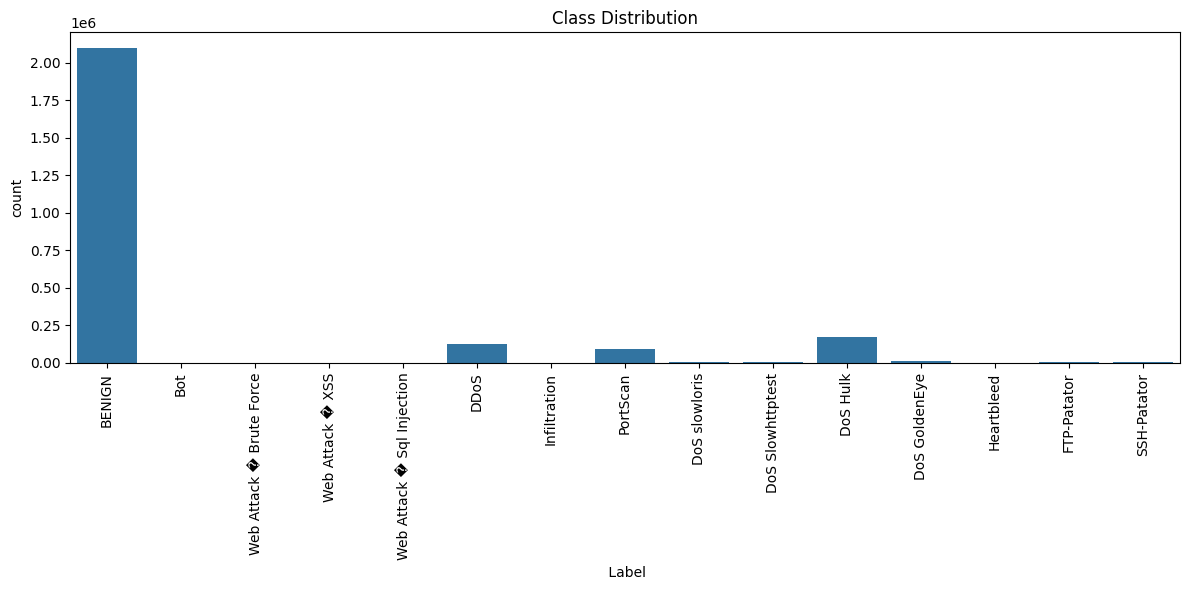

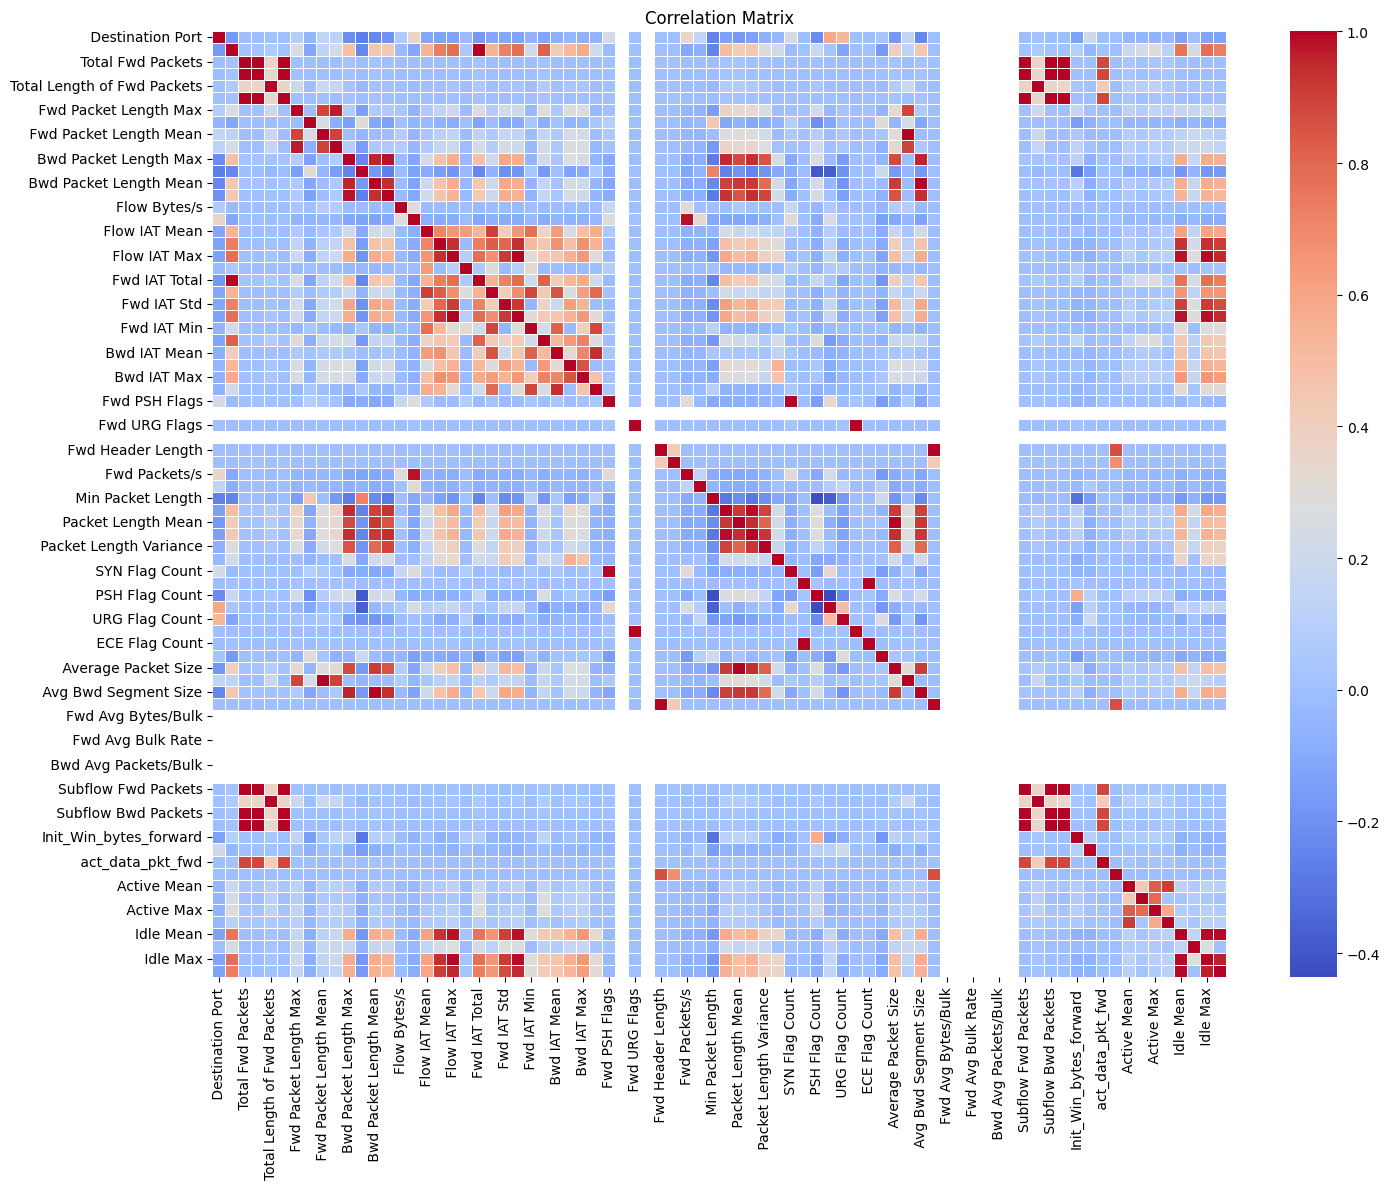

In [15]:
# Perform EDA
perform_eda(df_processed)

Engineering features using PCA

Engineering features...
Checking for NaN values:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64
Checking for infinite values:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Active Min                    0
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Length: 78, dtype: int64
Checking max values before scaling:
  Destination Port                  65535.0
 Flow Duration                 119999998.0
 Total Fwd Packets  

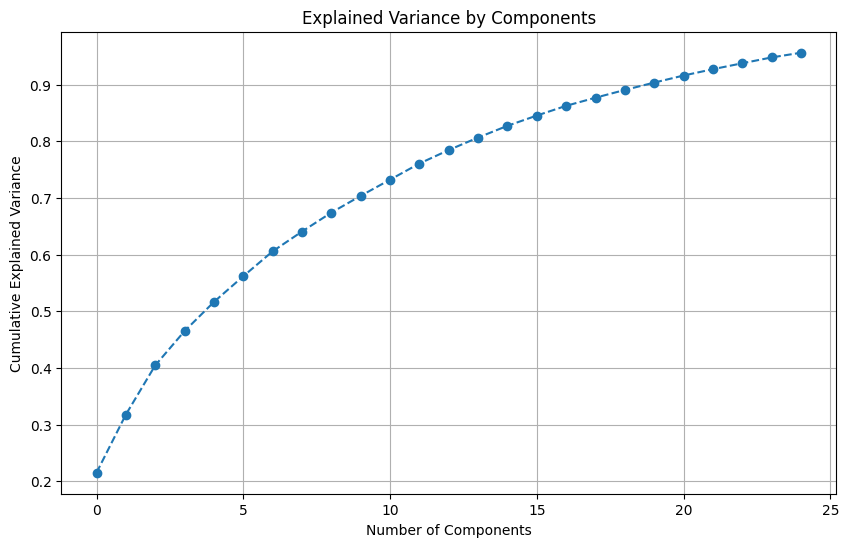

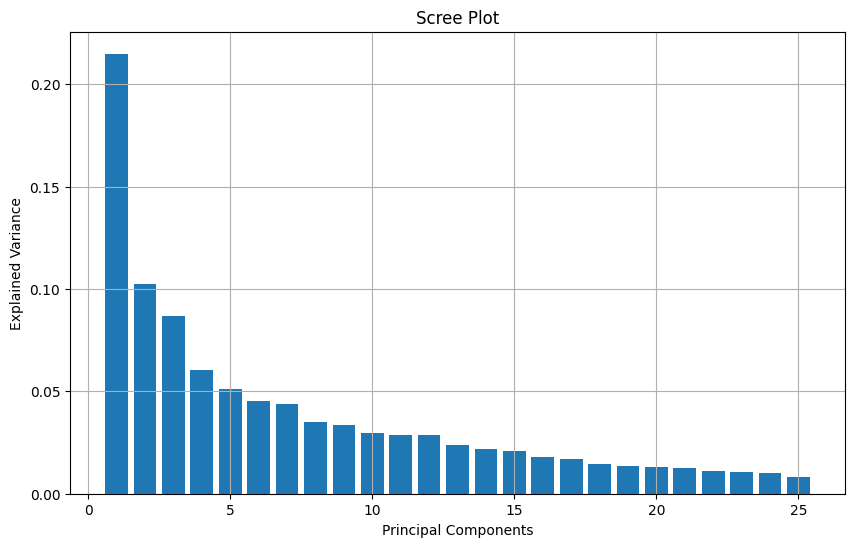

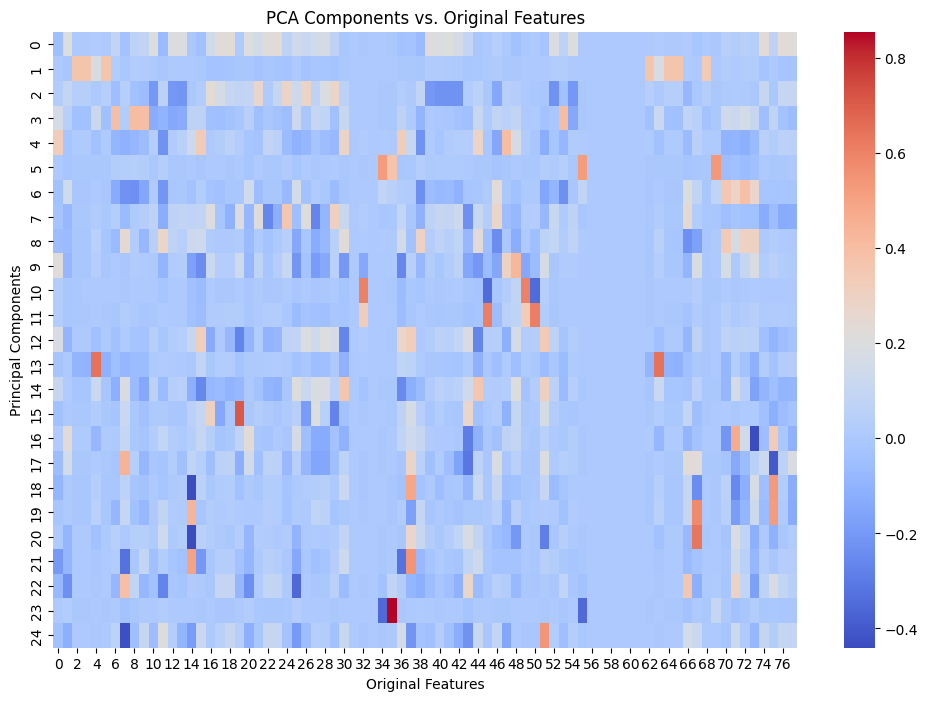

In [16]:
# Engineer features
X_pca, y, pca = engineer_features(df_processed)

Training and testing all the models

In [17]:
# Handle class imbalance (train resampled, test unchanged)
X_train, y_train, X_test, y_test = handle_imbalance(X_pca, y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Reducing dataset to 7.5% for training before handling class imbalance...
Shape after downsampling for training: (25220, 25)
Shape after resampling for training: (251532, 25)
Class distribution after resampling for training:
 Label
BENIGN                      20961
Bot                         20961
DDoS                        20961
DoS GoldenEye               20961
DoS Hulk                    20961
DoS Slowhttptest            20961
DoS slowloris               20961
FTP-Patator                 20961
PortScan                    20961
SSH-Patator                 20961
Web Attack � Brute Force    20961
Web Attack � XSS            20961
Name: count, dtype: int64
Shape of test set (unaltered): (189150, 25)
Training set shape: (251532, 25)
Testing set shape: (189150, 25)


Training and evaluating models...

Training Random Forest...
Random Forest Results:
Accuracy: 0.9896
Precision: 0.9927
Recall: 0.9896
F1 Score: 0.9910

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    157210
           1       0.10      0.57      0.18       147
           2       1.00      0.99      0.99      9601
           3       0.91      0.95      0.93       771
           4       0.99      0.99      0.99     12963
           5       0.87      0.83      0.85       392
           6       0.87      0.90      0.88       404
           7       1.00      0.94      0.97       445
           8       0.96      0.98      0.97      6811
           9       1.00      0.86      0.93       241
          10       0.62      0.55      0.58       110
          11       0.52      0.49      0.51        49

    accuracy                           0.99    189144
   macro avg       0.82      0.84      0.81    189144
weighted avg 

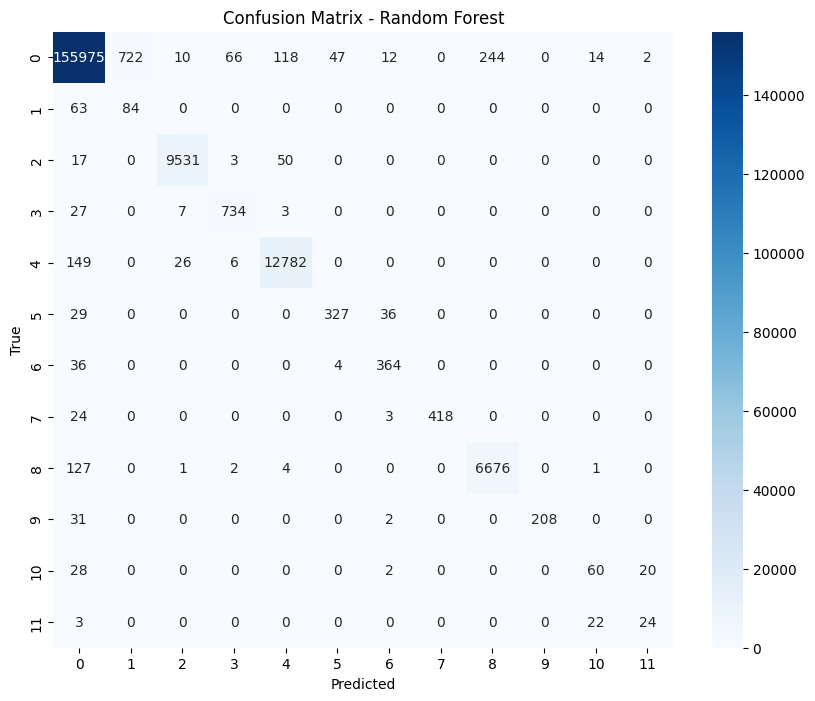

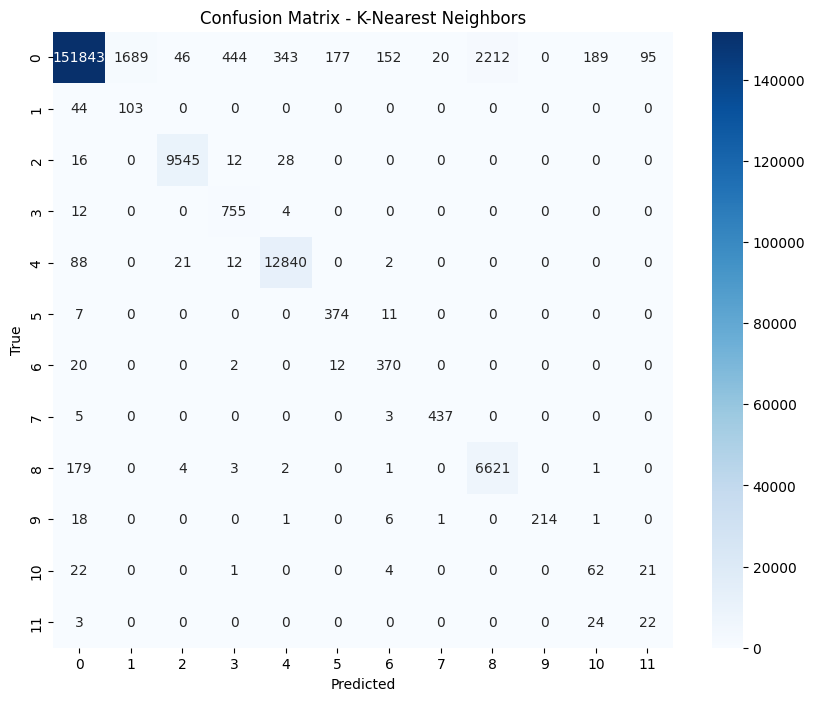

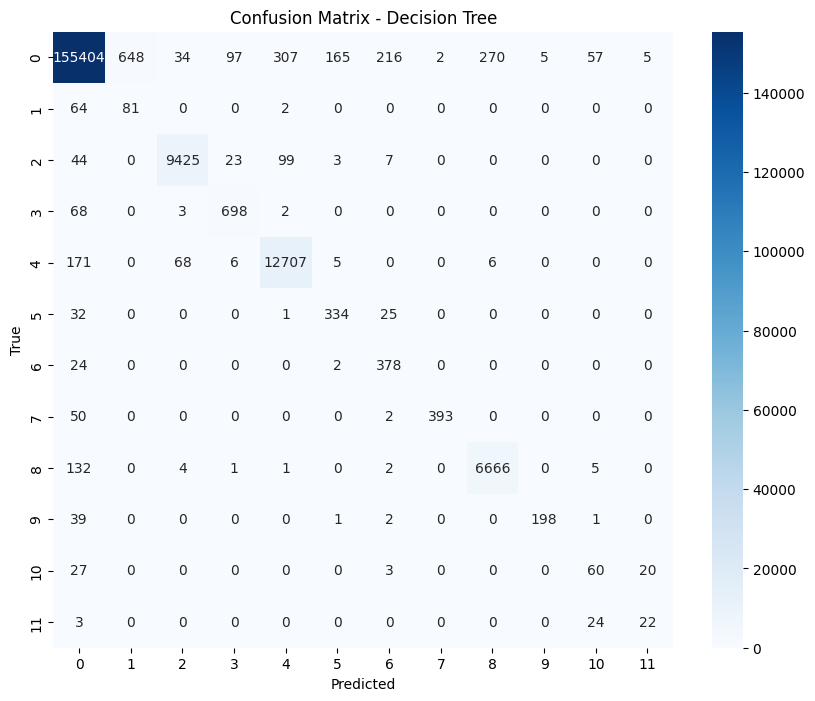

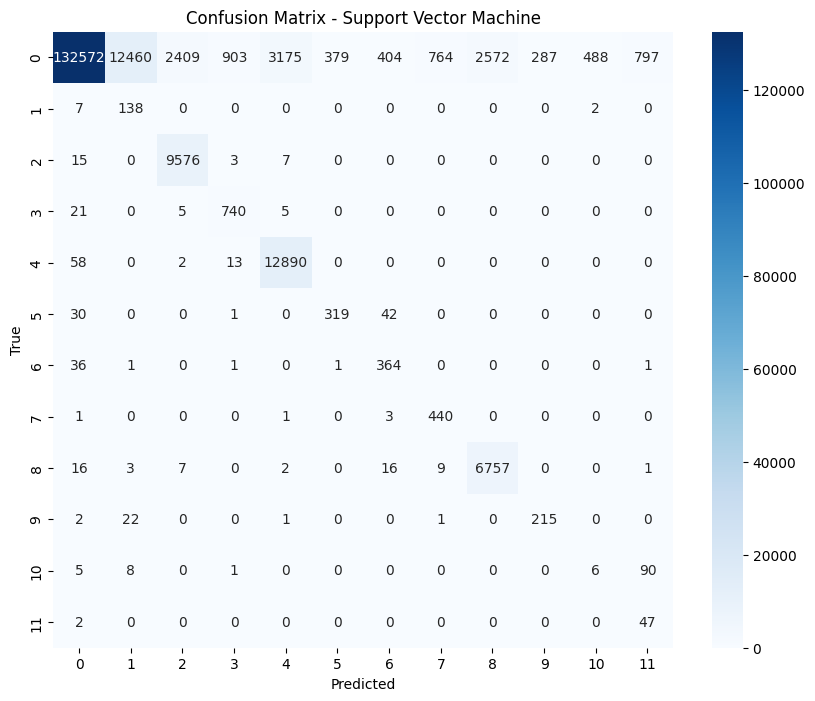

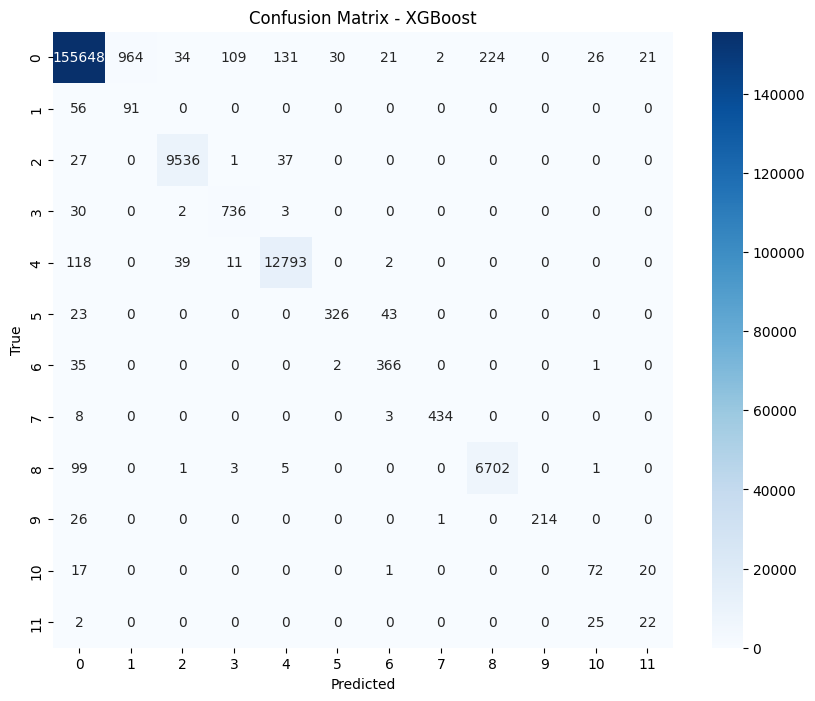

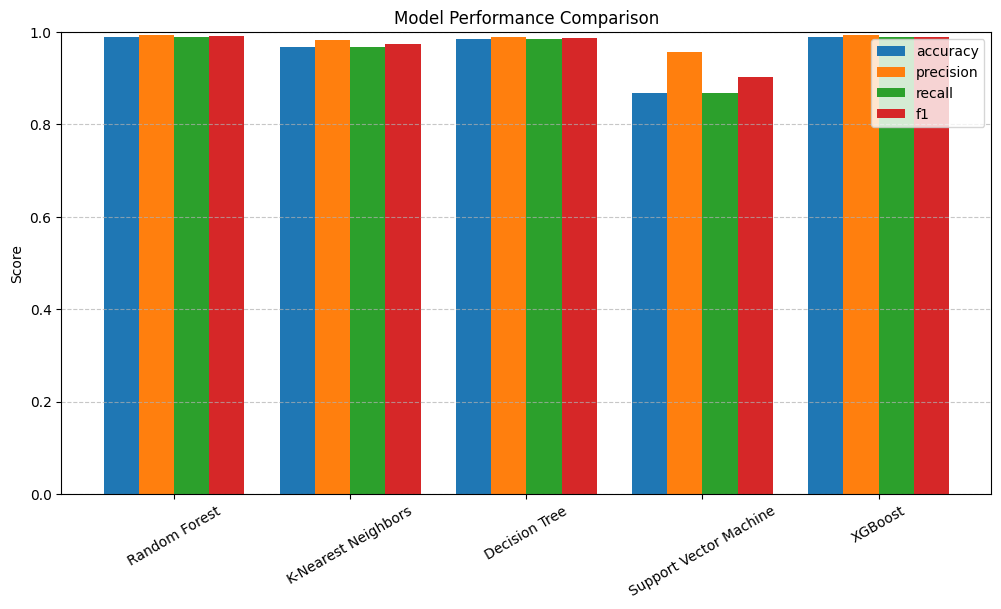

In [18]:

# Train and evaluate models
results, _ = train_evaluate_models(X_train, X_test, y_train, y_test)

Feature Visualization for Random Forests, Decision Tree and XGBoost

Feature importance for Random Forest:
Visualizing feature importance...
Feature importance for Decision Tree:
Visualizing feature importance...
Feature importance for XGBoost:
Visualizing feature importance...


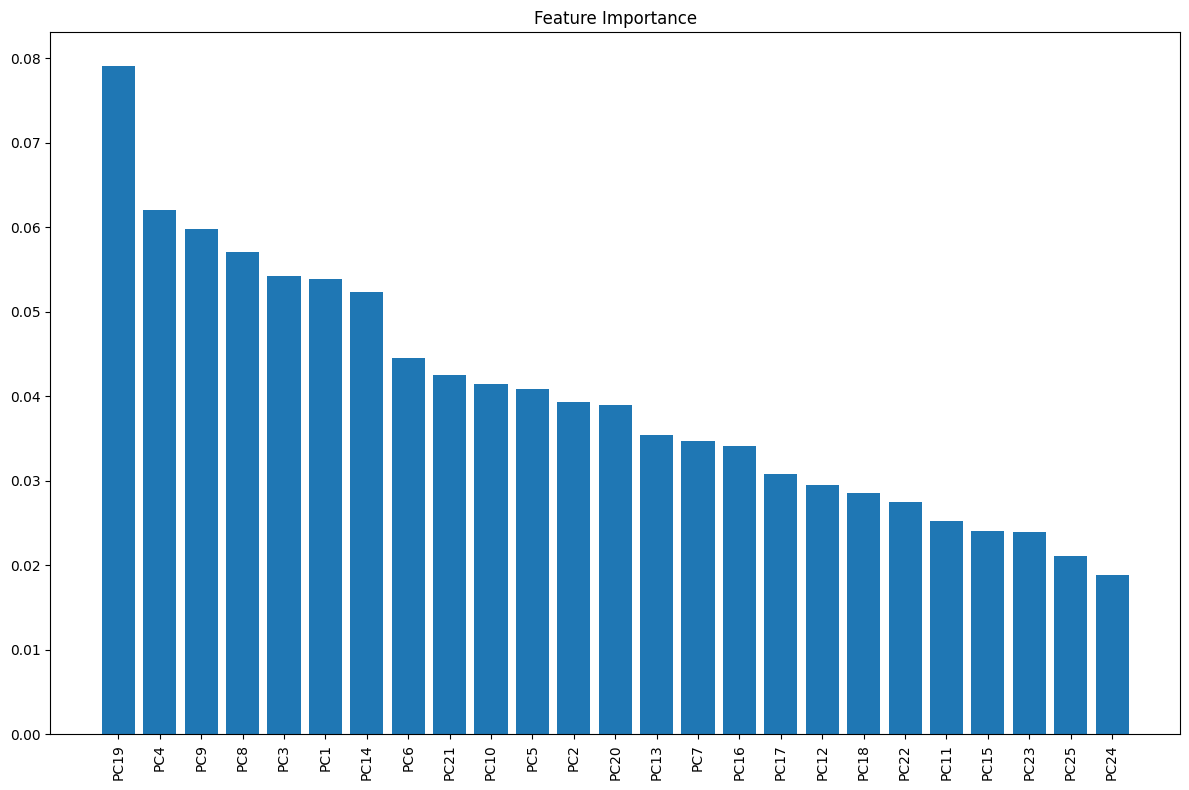

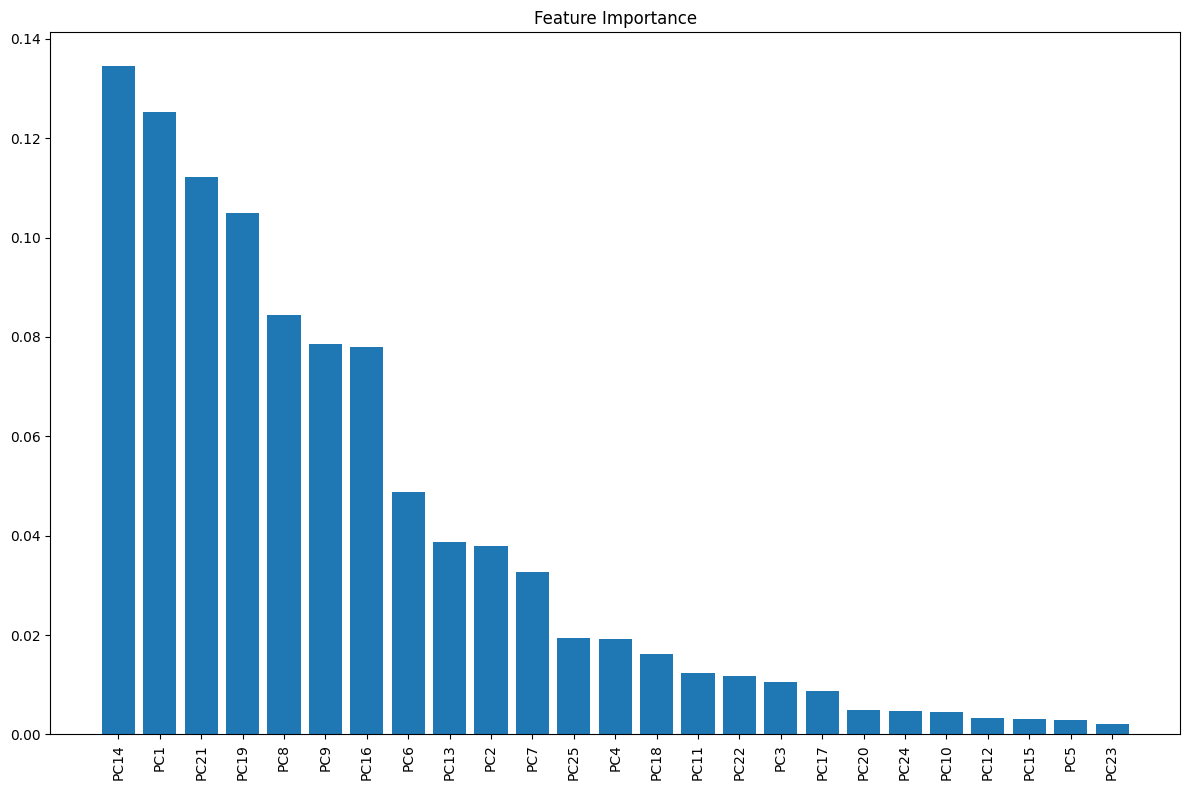

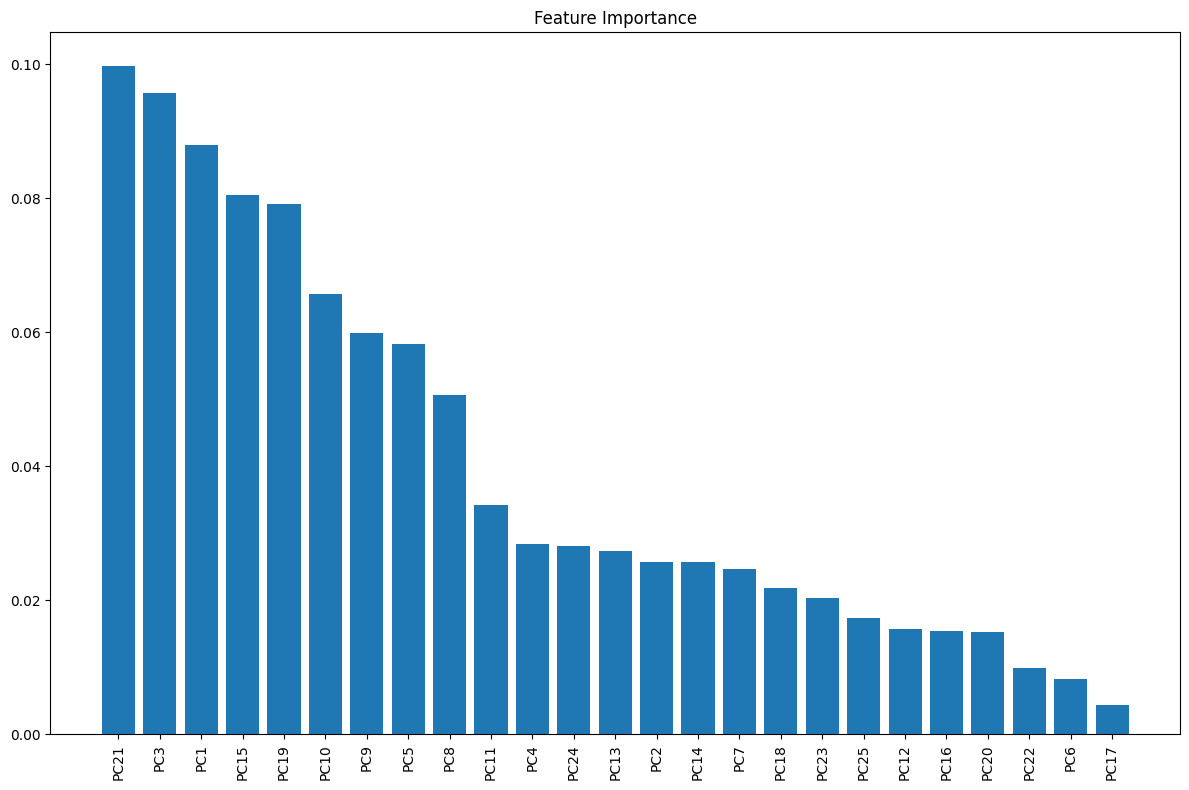

In [19]:
# Visualize feature importance for models that support it
for model_name, result in results.items():
    model = result['model']

    # Skip models that don't have feature importance attributes
    if hasattr(model, 'feature_importances_'):
        print(f"Feature importance for {model_name}:")

        # Create feature names for PCA components
        feature_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

        # Visualize feature importance
        visualize_feature_importance(model, feature_names)

